In [66]:
%matplotlib inline
import numpy as np
import os
import pickle 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt

In [67]:
# Expected shape is 1175 Trials x 13 channels x 5000 samples (@ 5000Hz) - value is potential
raw_source_dir = "custom_preprocess/"

files = ['x_new', 'y_new', 'median_new'] # Also consider y.pickle (unlabeled)
file_data = []
for i, fn in enumerate(files):
    with open(os.path.join(raw_source_dir, '{}.pickle'.format(fn)), 'rb') as f:
        file_data.append(np.array(pickle.load(f)))
        
x = file_data[0]
y = file_data[1]
y_med = file_data[2]
print(x.shape)
print(y.shape)
print(y_med.shape)

(1459, 13, 5010)
(1459,)
(1459,)


[19.5 29.5 23.  20.  19.  24.  20.  26.  19.5 25.5 20.  24.  17.5 34.
 25.5 18.  21.5 23.5 19.  28.5]
[0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1]


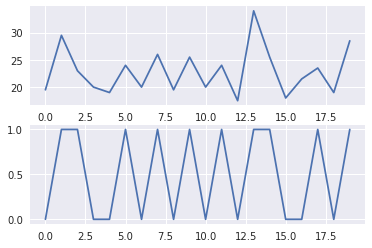

In [68]:
fig, ax = plt.subplots(2,1)
plt.figure(figsize=(30,10))
ax[0].plot(y[:20])
ax[1].plot(y_med[:20])
print(y[:20])
print(y_med[:20])

In [69]:
seed = 1
np.random.seed(seed)

In [25]:
# Referencing http://forrestbao.blogspot.com/2009/10/eeg-signal-processing-in-python-and.html
# And https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/

# Sliding window spectrogram

def create_spectrogram(eeg_signal, save=False, save_name='x_fft.pickle', fs=5000.0, window_length=2500, step_size=50, banded_freq=40):
    # Shape trials x channels x samples

    # Create windows
    sample_length = eeg_signal.shape[-1]
    
    # Hyperparams
    # fs: sampling frequency
    # window_length : snippet to take fft over. resolution = fs/window_length
    # step_size: how fast to roll the window
    # banded_freq: how many steps of the frequency output to take - freq range [0, resolution * banded_freq]
    
    roll_cap = (sample_length - window_length)//step_size + 1 # Number of windows
    roll_ctr = 0
    # return trial x channel x windows x freq band
    fft_over_time = np.zeros((eeg_signal.shape[0], eeg_signal.shape[1], roll_cap, banded_freq))

    # Could consider vectorizing...
    while roll_ctr < roll_cap:
        window_sample = eeg_signal[...,roll_ctr * step_size: roll_ctr * step_size + window_length]
        fft_over_time[..., roll_ctr,:] = np.abs(np.fft.rfft(window_sample)[...,:banded_freq]) / window_length # fft over whole time frame
        roll_ctr += 1
    if save:
        with open(save_name, "wb") as pf:
            pickle.dump(fft_over_time, pf)
        print("Done pickling {}".format(save_name))
    return fft_over_time
    

In [26]:
def create_angles_spec(eeg_signal, save=False, save_name='x_angles.pickle', fs=5000.0, window_length=2500, step_size=50, banded_freq=40):
    # Create windows
    sample_length = eeg_signal.shape[-1]
    
    # Hyperparams
    # fs: sampling frequency
    # window_length : snippet to take fft over. resolution = fs/window_lenth
    # step_size: how fast to roll the window
    # banded_freq: how many steps of the frequency output to take - freq range [0, resolution * banded_freq]
    
    roll_cap = (sample_length - window_length)//step_size + 1 # Number of windows
    roll_ctr = 0

    fft_over_time = np.zeros((eeg_signal.shape[0], eeg_signal.shape[1], roll_cap, banded_freq))
    # Masking threshold for noise
    signal_thresh = .1
    while roll_ctr < roll_cap:
        window_sample = eeg_signal[...,roll_ctr * step_size: roll_ctr * step_size + window_length]
        fft = np.fft.rfft(window_sample)[...,:banded_freq] # use as mask
        fft_over_time[..., roll_ctr,:] = np.where(np.abs(fft)/window_length > signal_thresh, np.angle(fft), 0)
        roll_ctr += 1
    if save:
        with open(save_name, "wb") as pf:
            pickle.dump(fft_over_time, pf)
        print("Done pickling {}".format(save_name))
    return fft_over_time
    

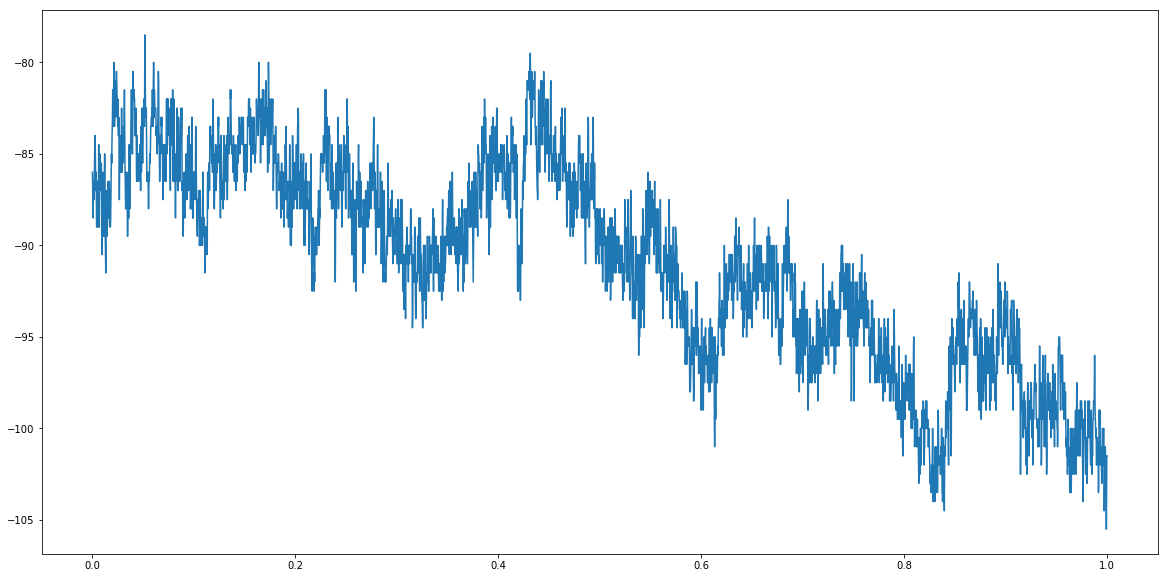

In [28]:
t = np.linspace(0, 1, x[0,0].shape[0])
plt.figure(figsize=(20,10))
plt.plot(t, x[25,0])


In [93]:
win_length = 4000
resolution = 5000/win_length
x_fft_all = create_spectrogram(x, 'x_fft.pickle', window_length=win_length, banded_freq=25)

Done pickling x_fft.pickle


(1459, 13, 21, 25)


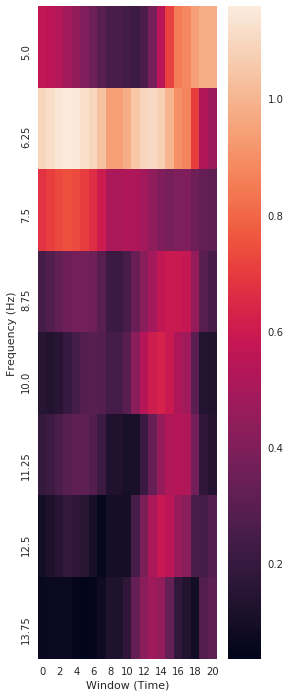

In [94]:
# Drop the first bin to account for DC offset
print(x_fft_all.shape)
# Find the channels with way too much power: > 3
freq_crop = x_fft_all[:,:10,:,4:12]
spectro = freq_crop[0,0].T

sns.set(rc={'figure.figsize':(4,12)})
ax = sns.heatmap(spectro, yticklabels=(np.arange(spectro.shape[0]) + 4)*resolution)
ax.set(ylabel='Frequency (Hz)', xlabel='Window (Time)')
plt.show()

In [71]:
angle_fft_all = create_angles_spec(x, window_length=4000, banded_freq=20) # resolution: 1.25

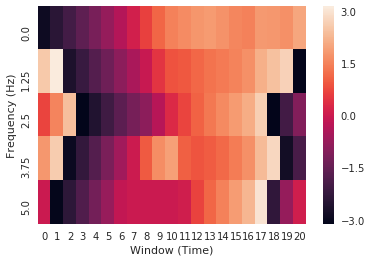

In [73]:
resolution=1.25
angle_spectro = angle_fft_all[0,0,:,6:11].T
ax = sns.heatmap(angle_spectro, yticklabels=np.arange(angle_spectro.shape[0])*resolution)
ax.set(ylabel='Frequency (Hz)', xlabel='Window (Time)')
plt.show()

In [90]:
print(angle_fft_all.shape)
# Take C3, last 5 windows, 8-12 Hz - 6:11
angle_flattened = angle_fft_all[:,4,-5:,7].reshape((angle_fft_all.shape[0], -1))
print(angle_flattened.shape)
a_x_tr, a_x_te, a_y_tr, a_y_te = train_test_split(angle_flattened, y_med, test_size=.2, random_state=seed)

(1459, 13, 21, 20)
(1459, 5)


In [137]:
print(freq_crop.shape)
power_flattened = freq_crop[:,:,-2:].reshape((freq_crop.shape[0], -1)) # flatten channels, frequencies, and windows
print(power_flattened.shape)
# y_med_cross = np.concatenate((y_med[:,np.newaxis],np.logical_not(y_med[:,np.newaxis])), axis=1)
x_tr, x_te, y_tr, y_te = train_test_split(power_flattened, y_med, test_size=.2, random_state=seed)
print(x_tr.shape)
print(y_tr.shape)

(1459, 10, 21, 8)
(1459, 160)
(1167, 160)
(1167,)


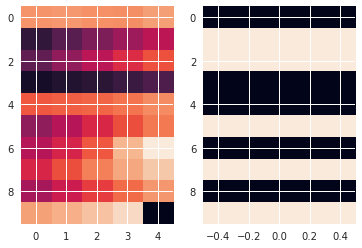

In [92]:
plt.subplot(121)
plt.imshow(angle_flattened[:10], aspect='auto')
plt.subplot(122)
plt.imshow(np.array([y_med[:10]]).transpose(), aspect='auto')

In [111]:
from sklearn.neural_network import MLPClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(random_state=seed,max_depth=2)
clf.fit(x_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [117]:
from keras.models import Sequential
from keras.layers import Dense
angle_model = Sequential()
angle_model.add(Dense(30, input_dim=angle_flattened.shape[-1], activation='relu'))
angle_model.add(Dense(30, activation='relu'))
angle_model.add(Dense(1, activation='sigmoid'))
# angle_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
angle_model.compile(loss='binary_crossentropy', optimizer='adam')

angle_model.fit(a_x_tr, a_y_tr, epochs=12, batch_size=8,validation_split=0.2)

Train on 933 samples, validate on 234 samples
Epoch 1/12
933/933 [==============================] - 2s 2ms/step - loss: 0.6974 - val_loss: 0.7029
Epoch 2/12
933/933 [==============================] - 0s 222us/step - loss: 0.6925 - val_loss: 0.6964
Epoch 3/12
933/933 [==============================] - 0s 213us/step - loss: 0.6924 - val_loss: 0.6989
Epoch 4/12
933/933 [==============================] - 0s 257us/step - loss: 0.6909 - val_loss: 0.6918
Epoch 5/12
933/933 [==============================] - 0s 216us/step - loss: 0.6925 - val_loss: 0.6999
Epoch 6/12
933/933 [==============================] - 0s 264us/step - loss: 0.6891 - val_loss: 0.7061
Epoch 7/12
933/933 [==============================] - 0s 240us/step - loss: 0.6882 - val_loss: 0.7085
Epoch 8/12
933/933 [==============================] - 0s 253us/step - loss: 0.6909 - val_loss: 0.6957
Epoch 9/12
933/933 [==============================] - 0s 270us/step - loss: 0.6893 - val_loss: 0.7030
Epoch 10/12
933/933 [=================

In [168]:
print(power_flattened.shape)
model = Sequential()
model.add(Dense(80, input_dim=power_flattened.shape[-1], activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_tr, y_tr, epochs=10, batch_size=16, validation_split=0.2)

(1459, 160)
Train on 933 samples, validate on 234 samples
Epoch 1/10
933/933 [==============================] - 3s 3ms/step - loss: 1.0115 - acc: 0.5038 - val_loss: 0.8614 - val_acc: 0.5427
Epoch 2/10
933/933 [==============================] - 0s 175us/step - loss: 0.8603 - acc: 0.5520 - val_loss: 0.8407 - val_acc: 0.5684
Epoch 3/10
933/933 [==============================] - 0s 162us/step - loss: 0.8545 - acc: 0.5080 - val_loss: 0.9368 - val_acc: 0.5513
Epoch 4/10
933/933 [==============================] - 0s 174us/step - loss: 0.8528 - acc: 0.5102 - val_loss: 0.8825 - val_acc: 0.4316
Epoch 5/10
933/933 [==============================] - 0s 158us/step - loss: 0.8227 - acc: 0.5584 - val_loss: 0.8389 - val_acc: 0.5556
Epoch 6/10
933/933 [==============================] - 0s 239us/step - loss: 0.7521 - acc: 0.5456 - val_loss: 0.8220 - val_acc: 0.5513
Epoch 7/10
933/933 [==============================] - 0s 250us/step - loss: 0.8406 - acc: 0.5155 - val_loss: 0.9178 - val_acc: 0.4658
Epoch 

In [58]:
# Sanity check on original distr
print(np.unique(a_y_tr, return_counts=True))
print(np.unique(a_y_te, return_counts=True))

(array([0, 1]), array([479, 480]))
(array([0, 1]), array([124, 116]))


In [127]:
a_y_pred_tr = angle_model.predict_classes(a_x_tr)
a_y_pred_te = angle_model.predict_classes(a_x_te)
print(np.unique(a_y_pred_tr,return_counts=True))
print("Train:", accuracy_score(a_y_tr, a_y_pred_tr))
print("Test:", accuracy_score(a_y_te, a_y_pred_te))

(array([0, 1], dtype=int32), array([1099,   68]))
Train: 0.5424164524421594
Test: 0.5136986301369864


In [169]:
y_pred_tr = model.predict_classes(x_tr)
print(y_pred_tr.shape)
print(np.unique(y_pred_tr,return_counts=True))
te_prob = model.predict(x_te)[:,0]
y_pred_te = model.predict_classes(x_te)
print(np.std(te_prob))
print(np.max(te_prob))
top_y = te_prob.argsort()[::-1][:10]
print(y_te[top_y])
print("Train:", accuracy_score(y_tr, y_pred_tr))
print("Test:", accuracy_score(y_te, y_pred_te))

(1167, 1)
(array([0, 1], dtype=int32), array([1080,   87]))
0.10974848
0.9999964
[0 0 0 1 1 0 1 1 0 1]
Train: 0.5586975149957155
Test: 0.5034246575342466


In [110]:
predict = clf.predict(x_te)
predict_tr = clf.predict(x_tr)
u, counts = np.unique(y_med, return_counts=True)
print(accuracy_score(predict_tr, y_tr))
print(accuracy_score(predict, y_te))

0.6495287060839761
0.476027397260274


In [28]:

scores = cross_val_score(clf, power_flattened, y[:-1], cv=5)
print(scores)


[0.46391753 0.49140893 0.50344828 0.52413793 0.49310345]
